In [1]:
import sys
sys.path.append('../..')
from TO.utils import check_package_status
check_package_status()

from experiments.utils import set_plt_template
set_plt_template()

<div class="alert alert-block alert-success" style="font-size: 14px; border-radius: 10px"><h4>[GO] TO @ 5079ea2d405e67ca028f48ad74e38d384611772f
</h4><pre>  ✅ No changes found in the ./TO packge.</pre></div>

In [2]:
from TO.parameterizations import Rectangles, LameCurves, Capsules
from TO.parameterizations.mmc import MMCCenterpointsConfig

from TO import Topology
from TO.models import BinaryElasticMembraneModel

from TO.experiment import run_experiment

import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box

from tqdm import trange
from IPython.utils.io import capture_output

In [3]:
topology = Topology(
    continuous=True, 
    domain=box(0, 0, 100, 50), 
    density=1.0
)
model = BinaryElasticMembraneModel(
    topology, 
    thickness=1, 
    E11=25, 
    E22=1, 
    G12=0.5, 
    nu12=0.25, 
    Emin=1e-9
)

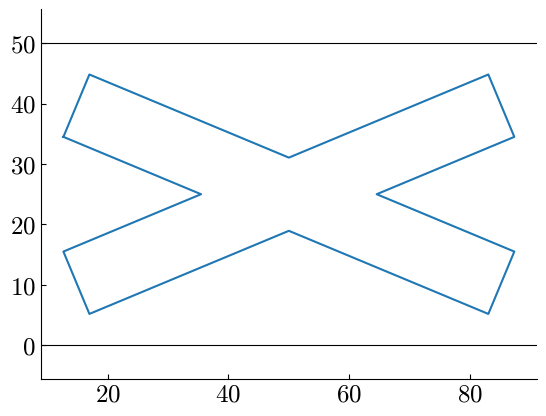

In [4]:
parameterization_rectangles = Rectangles(
    topology,
    representation=MMCCenterpointsConfig,
    symmetry_x=False, 
    symmetry_y=True, 
    n_components_x=3, 
    n_components_y=2, 
    n_samples=100,
)

x_configs = np.zeros(parameterization_rectangles.dimension).reshape(-1, 5)
# (x1, y1, x2, y2, r) in normalized coordinates
x_configs[0] = (0.2, 1/4, 0.8, 3/4, .1)

parameterization_rectangles.update_topology(topology, x_configs)

plt.plot(*topology.geometry.geoms[0].exterior.xy); plt.axhline(0, c='k', lw=.8); plt.axhline(50, c='k', lw=.8); plt.axis('equal');

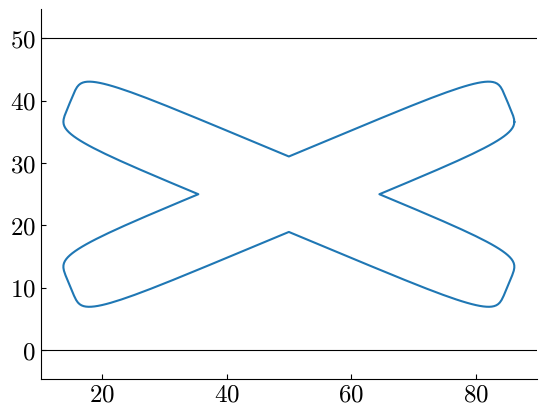

In [5]:
parameterization_lame = LameCurves(
    topology,
    representation=MMCCenterpointsConfig,
    symmetry_x=False, 
    symmetry_y=True, 
    n_components_x=3, 
    n_components_y=2, 
    n_samples=100,
    m=6
)

x_configs = np.zeros(parameterization_lame.dimension).reshape(-1, 5)
# (x1, y1, x2, y2, r) in normalized coordinates
x_configs[0] = (0.2, 1/4, 0.8, 3/4, .1)

parameterization_lame.update_topology(topology, x_configs)

plt.plot(*topology.geometry.geoms[0].exterior.xy); plt.axhline(0, c='k', lw=.8); plt.axhline(50, c='k', lw=.8); plt.axis('equal');

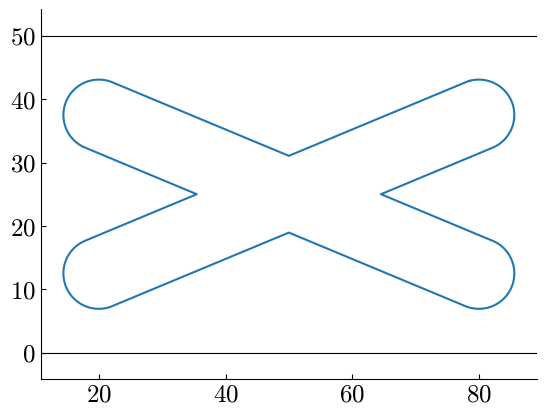

In [6]:
parameterization_capsules = Capsules(
    topology,
    representation=MMCCenterpointsConfig,
    symmetry_x=False, 
    symmetry_y=True, 
    n_components_x=3, 
    n_components_y=2, 
    n_samples=100,
)

x_configs = np.zeros(parameterization_capsules.dimension).reshape(-1, 5)
# (x1, y1, x2, y2, r) in normalized coordinates
x_configs[0] = (0.2, 1/4, 0.8, 3/4, .1)

parameterization_capsules.update_topology(topology, x_configs)

plt.plot(*topology.geometry.geoms[0].exterior.xy); plt.axhline(0, c='k', lw=.8); plt.axhline(50, c='k', lw=.8); plt.axis('equal');

In [7]:
n_runs = 30
budget = 500

for (exp, parameterization) in [
    ('rectangles', parameterization_rectangles),
    ('lame', parameterization_lame),
    ('capsules', parameterization_capsules)
] :
    print(type(parameterization))
    for seed in trange(n_runs):
        with capture_output():
            run_experiment(
                topology, parameterization, model,
                sigma0=0.25, budget=budget, seed=seed+1,
                name=exp
            )

<class 'TO.parameterizations.rectangle.Rectangles'>


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [23:56<00:00, 47.90s/it]


<class 'TO.parameterizations.lame_curve.LameCurves'>


100%|██████████| 30/30 [24:14<00:00, 48.50s/it]


<class 'TO.parameterizations.capsule.Capsules'>


100%|██████████| 30/30 [25:44<00:00, 51.49s/it]


# Analysis

In [12]:
from TO.utils import get_fitness_values, get_best_config

rectangles
[001/030] converged before calling the simulation
[002/030] converged before exceeded budget @ 39 with fitness 0.09306518893831879
[003/030] converged before exceeded budget @ 105 with fitness 0.21954008283294751
[029/030] converged before calling the simulation
[030/030] converged before calling the simulation
lame
[001/030] converged before calling the simulation
[029/030] converged before calling the simulation
[030/030] converged before calling the simulation
capsules
[001/030] converged before calling the simulation
[029/030] converged before calling the simulation


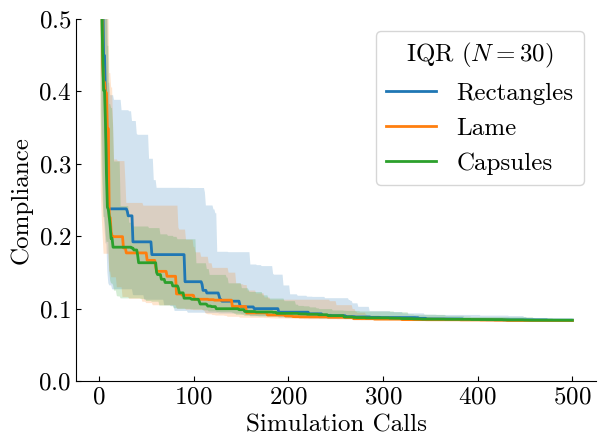

In [11]:
fig, ax = plt.subplots()

experiment_names = ('rectangles', 'lame', 'capsules')
experiments = {exp: None for exp in experiment_names}
for exp in experiment_names:
    print(exp)
    X = np.empty((n_runs, budget))
    for i in range(n_runs) :
        try:
            x = get_fitness_values(exp, i)
            X[i,:x.size] = np.minimum.accumulate(x)
            if (x.size < budget) :
                print(f'[{i+1:03d}/{n_runs:03d}] converged before exceeded budget @ {x.size} with fitness {x.min()}')
                X[i,x.size:] = x.min()
        except FileNotFoundError:
            print(f'[{i+1:03d}/{n_runs:03d}] converged before calling the simulation')
            X[i, :] = np.nan 
    experiments[exp] = X.copy()
    X = X[~np.isnan(X).any(axis=1)]

    (Q2) = np.median(X, axis=0)
    (Q1, Q3) = np.percentile(X, [25, 75], axis=0)

    ax.plot(np.arange(budget)+1, Q2, lw=2, label=exp.capitalize())
    ax.fill_between(np.arange(budget)+1, Q1, Q3, alpha=.2)
ax.set_ylim(0, 0.5)

ax.legend(title=f'IQR ($N={n_runs}$)');ax.set_xlabel('Simulation Calls'); ax.set_ylabel('Compliance'); fig.tight_layout()

rectangles
[017/030] best is 6.75% lower than the median
lame
[024/030] best is 3.89% lower than the median
capsules
[017/030] best is 1.53% lower than the median


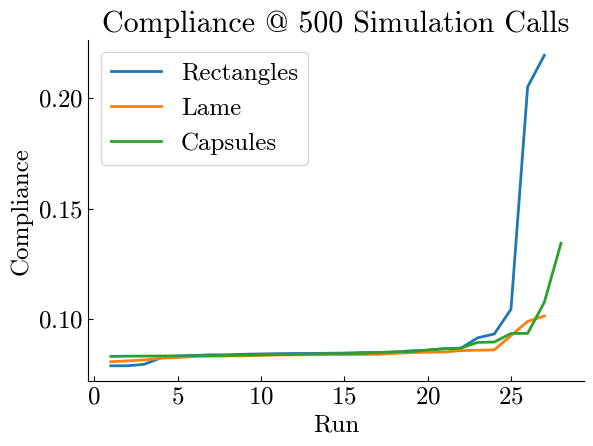

In [18]:
fig, ax = plt.subplots()
for exp in experiment_names :
    print(exp)
    f = experiments[exp][:,-1]
    diff = (np.nanmedian(f) - np.nanmin(f)) / np.nanmedian(f)
    print(f'[{np.nanargmin(f)+1:03d}/{n_runs:03d}] best is {diff*100:.2f}% lower than the median')

    ax.plot(np.arange(n_runs)+1, np.sort(f), lw=2, label=exp.capitalize())
ax.set_xlabel('Run'); ax.set_ylabel('Compliance'); ax.set_title('Compliance @ 500 Simulation Calls'); ax.legend()
fig.tight_layout()

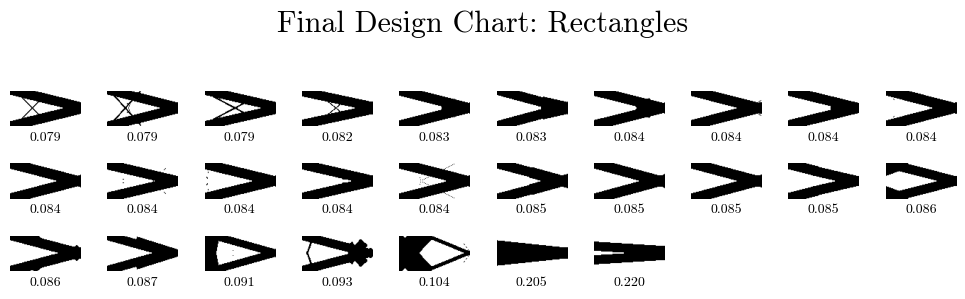

In [ ]:
exp = 'rectangles'
parameterization = parameterization_rectangles

idx = experiments[exp][:,-1].argsort().reshape(-1, 10)

fig, ax = plt.subplots(*idx.shape, figsize=(10,len(idx)))

for i in range(len(idx)):
    for j in range(len(idx[0])) :
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].spines[:].set_visible(False)
        if np.isnan(experiments[exp][idx[i,j]]).any() : continue
        parameterization.update_topology(topology, get_best_config(exp, idx[i,j]))
        ax[i,j].imshow(topology.mask, cmap='binary')
        ax[i,j].set_xlabel(f'{get_fitness_values(exp.lower(), idx[i,j]).min():.3f}', fontsize=10)
fig.suptitle(f'Final Design Chart: {exp.capitalize()}')
fig.tight_layout()

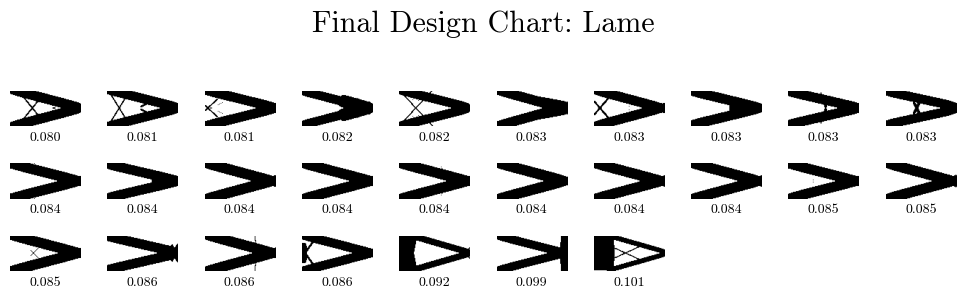

In [15]:
exp = 'lame'
parameterization = parameterization_lame

idx = experiments[exp][:,-1].argsort().reshape(-1, 10)

fig, ax = plt.subplots(*idx.shape, figsize=(10,len(idx)))

for i in range(len(idx)):
    for j in range(len(idx[0])) :
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].spines[:].set_visible(False)
        if np.isnan(experiments[exp][idx[i,j]]).any() : continue
        parameterization.update_topology(topology, get_best_config(exp, idx[i,j]))
        ax[i,j].imshow(topology.mask, cmap='binary')
        ax[i,j].set_xlabel(f'{get_fitness_values(exp.lower(), idx[i,j]).min():.3f}', fontsize=10)
fig.suptitle(f'Final Design Chart: {exp.capitalize()}')
fig.tight_layout()

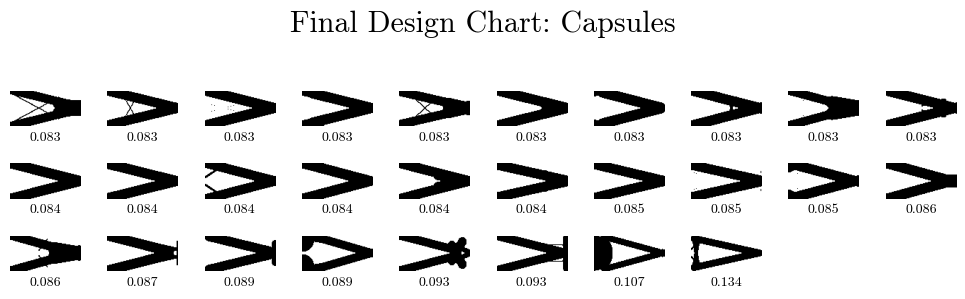

In [16]:
exp = 'capsules'
parameterization = parameterization_capsules

idx = experiments[exp][:,-1].argsort().reshape(-1, 10)

fig, ax = plt.subplots(*idx.shape, figsize=(10,len(idx)))

for i in range(len(idx)):
    for j in range(len(idx[0])) :
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].spines[:].set_visible(False)
        if np.isnan(experiments[exp][idx[i,j]]).any() : continue
        parameterization.update_topology(topology, get_best_config(exp, idx[i,j]))
        ax[i,j].imshow(topology.mask, cmap='binary')
        ax[i,j].set_xlabel(f'{get_fitness_values(exp.lower(), idx[i,j]).min():.3f}', fontsize=10)
fig.suptitle(f'Final Design Chart: {exp.capitalize()}')
fig.tight_layout()